![Banner](../media/banner2.png)

---
# Workshop 2.1: <font color=peru>R Demo Notebook</font>

* **Contributors**:
    * Ashwin Patil (@ashwinpatil)
    * Jose Rodriguez (@Cyb3rPandah)
    * Ian Hellen (@ianhellen)
<br><br>
* **Agenda**:
    * [Jupyter is not just Python](#notjustpython)
<br><br>
* **Notebook**: [https://aka.ms/Jupyterthon-ws-2-1](https://aka.ms/Jupyterthon-ws-2-1)
* **License**: [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/)

* **Q&A** - OTR Discord **#Jupyterthon #WORKSHOP DAY 2 - JUPYTER ADVANCED**

# Anomaly detection and threat hunting on Windows logon data using anomalize

Reference original blog post by Russ Mcree:
- https://holisticinfosec.blogspot.com/2018/06/toolsmith-133-anomaly-detection-threat.html


[Quick List of Useful Packages](https://support.rstudio.com/hc/en-us/articles/201057987-Quick-list-of-useful-R-packages)

![](https://upload.wikimedia.org/wikipedia/commons/f/f5/List-of-r-packages.png)

In [1]:
#Suppress R Warnings
options(warn=-1)
# Load R Packages
pkgs <- c(pkgs <- c("tibbletime", "tidyverse","anomalize", "jsonlite", "curl", "httr", "lubridate","dplyr"))
sapply(pkgs, function(x) suppressPackageStartupMessages(require(x, character.only = T)))

tibbletime  tidyverse  anomalize   jsonlite       curl       httr  lubridate 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE       TRUE 
     dplyr 
      TRUE

## Install Missing packages

In [2]:
install.packages("tibbletime")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
install.packages("anomalize")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [4]:
#Suppress R Warnings
options(warn=-1)
# Load R Packages
pkgs <- c(pkgs <- c("tibbletime", "tidyverse","anomalize", "jsonlite", "curl", "httr", "lubridate","dplyr"))
sapply(pkgs, function(x) suppressPackageStartupMessages(require(x, character.only = T)))

tibbletime  tidyverse  anomalize   jsonlite       curl       httr  lubridate 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE       TRUE 
     dplyr 
      TRUE

## Read csv using R

In [5]:
# Read CSV into R
urlfile<-'https://raw.githubusercontent.com/ashwin-patil/threat-hunting-with-notebooks/master/rawdata/UserLogons-demo.csv'
userlogondemo<-read.csv(urlfile)

## Printing the structure of the data

In [6]:
str(userlogondemo)

'data.frame':	2844 obs. of  6 variables:
 $ Date           : chr  "1/3/2018" "1/3/2018" "1/3/2018" "1/3/2018" ...
 $ EventId        : chr  "Microsoft-Windows-Security-Auditing:4624" "Microsoft-Windows-Security-Auditing:4624" "Microsoft-Windows-Security-Auditing:4624" "Microsoft-Windows-Security-Auditing:4624" ...
 $ AccountNtDomain: chr  "LABDOMAIN.LOCAL" "LABDOMAIN.LOCAL" "LABDOMAIN.LOCAL" "LABDOMAIN.LOCAL" ...
 $ AccountName    : chr  "SRVACCNT-01" "SRVACCNT-01" "SRVACCNT-01" "SRVACCNT-01" ...
 $ logontype      : int  10 11 2 4 7 10 4 3 3 5 ...
 $ TotalLogons    : int  28 2 15592 259 9 1 23 65 7 60 ...


## Printing Sample Rows from the dataset

In [7]:
head(userlogondemo)

,Date,EventId,AccountNtDomain,AccountName,logontype,TotalLogons
,<chr>,<chr>,<chr>,<chr>,<int>,<int>
1,1/3/2018,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,SRVACCNT-01,10,28
2,1/3/2018,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,SRVACCNT-01,11,2
3,1/3/2018,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,SRVACCNT-01,2,15592
4,1/3/2018,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,SRVACCNT-01,4,259
5,1/3/2018,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,SRVACCNT-01,7,9
6,1/3/2018,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,SRVACCNT-01,10,1


In [8]:
#Read Downloaded csv and arrange by columns
userlogonsummary <- userlogondemo %>%
                    arrange(AccountName,AccountNtDomain,Date)

In [9]:
# Aggregate By User Logon View
byuser <- userlogonsummary %>%
          mutate(Date = as.Date(Date, "%m/%d/%Y")) %>% 
          group_by(Date, AccountName) %>%
          summarise(logoncount=sum(TotalLogons)) %>% 
          ungroup() %>%
          arrange(AccountName, Date)

head(byuser)

`summarise()` has grouped output by 'Date'. You can override using the `.groups` argument.



Date,AccountName,logoncount
<date>,<chr>,<int>
2018-01-01,ASHWIN,563
2018-01-03,ASHWIN,1462
2018-01-04,ASHWIN,1416
2018-01-05,ASHWIN,2241
2018-01-06,ASHWIN,1830
2018-01-08,ASHWIN,278


# Time Series anomaly detection
Anomalize : https://github.com/business-science/anomalize
anomalize enables a tidy workflow for detecting anomalies in data. The main functions are time_decompose(), anomalize(), and time_recompose(). When combined, it’s quite simple to decompose time series, detect anomalies, and create bands separating the “normal” data from the anomalous data

anomalize has three main functions:

- `time_decompose()`: Separates the time series into seasonal, trend, and remainder components

- `anomalize()`: Applies anomaly detection methods to the remainder component.

- `time_recompose()`: Calculates limits that separate the “normal” data from the anomalies!

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

Converting from tbl_df to tbl_time.
Auto-index message: index = Date

frequency = 6 days

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

median_span = 53 days



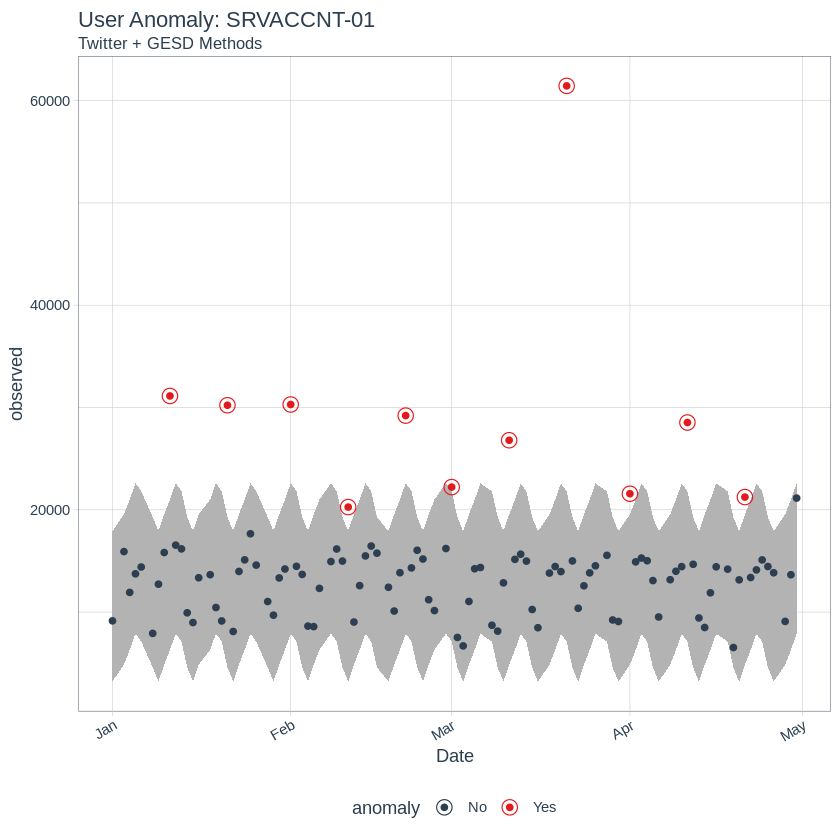

In [10]:
# Filtering dataset for specific User
FilteredAccount = "SRVACCNT-01"

# Ungroup dataset , run Time series decomposition method and plot anomalies
graphUser <- byuser %>%
  filter(AccountName == FilteredAccount) %>% 
  ungroup()%>%
  time_decompose(logoncount, method = "twitter", trend = "3 months") %>%
  anomalize(remainder, method = "gesd") %>%
  time_recompose() %>%
  # Anomaly Visualziation
  plot_anomalies(time_recomposed = TRUE) +
  labs(title = paste0("User Anomaly: ",FilteredAccount), subtitle = "Twitter + GESD Methods")

plot(graphUser)

Converting from tbl_df to tbl_time.
Auto-index message: index = Date

frequency = 6 days

median_span = 53 days



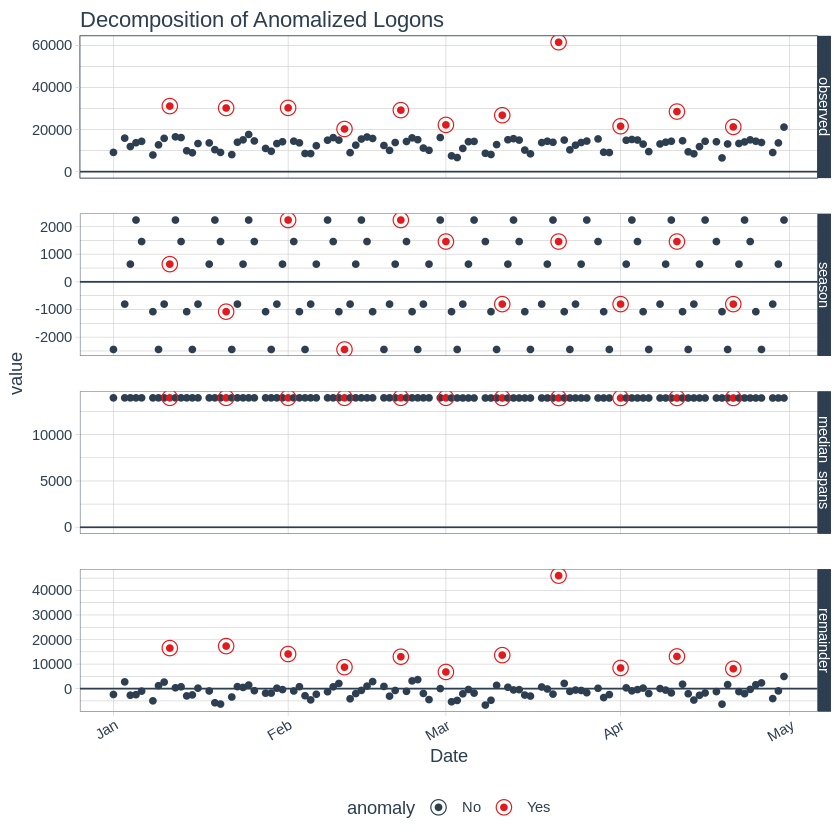

In [11]:
# Plot Time series decompositions components separately
byuser %>%
    filter(AccountName == FilteredAccount) %>% 
    ungroup()%>%
    time_decompose(logoncount, method = "twitter", trend = "3 months") %>%
    anomalize(remainder, method = "gesd") %>%
    plot_anomaly_decomposition() +
    labs(title = "Decomposition of Anomalized Logons")